<a href="https://colab.research.google.com/github/AldoVictorUliczki/UPSO-ELEMENTOS-DE-APRENDIZAJE-DE-M-QUINA-Y-BIG-DATA/blob/main/AldoUliczki_Laboratorio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Laboratorio 2: Clasificador de canciones de Spotify

###Integrante: Aldo Victor Uliczki
###Fecha de entrega:
###Miércoles, 08 de noviembre, 23:00 hs

###Introducción:
###Se desarrollará un programa que categorice canciones según las preferencias del usuario. Su función principal será predecir si una canción podría ser del gusto del usuario o no a través de herramientas de aprendizaje automático.

##Paso 0: Importar librerias y Cargar el dataset a Google Drive

In [ ]:
# Importar librerias
#para leer y graficar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#modelos de entrenamiento
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#para entrenar y ver rendimiento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

#para matriz de confusion
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount("drive",force_remount=True)
# Path del dataset
mi_ruta = "/content/drive/MyDrive/Colab Notebooks/Elementos de Aprendizaje de Máquina y Big Data/Laboratorio2/Canciones_Spotify.csv"

Mounted at drive


In [ ]:
# leemos el dataset y creamos una copia para trabajar
df = pd.read_csv(mi_ruta)
df_musica = df.copy()
df_musica.head(1)

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.0219,2,0.165,-8.795,1,0.431,150.062,4.0,0.286,1,Mask Off,Future


##Configuacion de los datos

En esta seccion se revisa el dataset proporcionado para determinar si hay campos vacios, luego se muestra informacion sobre el dataset como la cantidad de muestras y caracteristicas del mismo, y por ultimo se realizan graficos para visualizar el comportamiento del target en funcion de las distintas caracteristicas.

In [ ]:
# Revisamos si hay campos NaN en el dataframe
# Devuelve True si hay valores NaN en el dataframe
respuesta = df_musica.isnull().values.any()
respuesta

False

In [ ]:
#revisamos las caracteristicas del dataset
print("Forma del dataset:")
print(df_musica.shape)

muestra, caracteristicas = df_musica.shape

print("Muestras del dataset:")
print(muestra)
print("Caracteristicas del dataset:")
print(caracteristicas)

target_names = ["No me gusta", "Me gusta"]

counts = np.bincount(df_musica.target)
print("Balance de datos:")
for i, count in enumerate(counts):
    print(f"{target_names[i]}:   {count}")

Forma del dataset:
(2017, 17)
Muestras del dataset:
2017
Caracteristicas del dataset:
17
Balance de datos:
No me gusta:   997
Me gusta:   1020


Para la realizacion del grafico se tomo como caracteristica fija el 'instrumentalness' y se comparo con cada caracteristica del dataset para revisar como variaba el target(0 o 1) en cada caso.

In [ ]:
#Lista de Todos los parametros del dataset
lparam = ["acousticness","danceability","duration_ms","energy","instrumentalness","key","liveness","loudness","mode","speechiness","tempo","time_signature","valence"]

#esto define el tamaño del subplots en funcion de la cantidad de parametros de la lista
varRow = 0
varCol = 0
#si no hay resto == lista par
if len(lparam) % 2 == 0:
  varCol = 2                      #usamos 2 columnas
  varRow = int(len(lparam)/2)     #realizamos una division comun  para el numero de filas
# si hay resto == lista impar
else:
    varCol = 3                    #usamos 3 columnas
    varRow = int(len(lparam)//2)  #realizamos una division entera para el numero de filas


#creamos la figura con las filas y columnas ya definidas, y como titulo de c/subplot usamos el valor de la lisa
fig = make_subplots(rows = varRow, cols = varCol,
                    subplot_titles = [lparam[i] for i in range(len(lparam))] )

#definimos que colores vamos a utilizar para diferenciar el target
# blue == 0 => No me gusta
# red  == 1 => Me gusta
colores = ["blue", "red"]


# esto define la posicion del subplot a graficar
columna = 0
fila = 1
incremento = 1
for i in range(0,len(lparam)):
  if (columna < varCol):
    columna = columna + 1
  else:
    columna = 1
    incremento = incremento + 1
    fila = incremento

  # y en el bloque se grafica el subplot
  #Bloque (modificado del TP1)
  fig.add_trace(go.Scatter(
      x = df_musica["instrumentalness"],
      y = df_musica[lparam[i]],
      name = lparam[i],
      mode="markers",
      marker=dict(color=[colores[m] for m in df_musica["target"]]),
      yaxis ="y"),
                row = fila, col = columna)

fig.update_layout(title_text="instrumentalness vs:",height=1600, width=1200)
fig.show()

Luego de revisar los graficos se considero tomar las caracteristicas de ['instrumentalness','danceability','energy','liveness,'loudness','valence'] para en entrenamiento

In [ ]:
#definimos la etiqueta
y = df_musica['target']

In [ ]:
#definimos un conjunto de posibles datos de entrenamiento
X1 = df_musica[['instrumentalness','danceability','energy','liveness','loudness','valence']]  #PARAMETRO ELEGIDO POR NOSOTROS

#extras al azar
X2 = df_musica[['acousticness','instrumentalness','speechiness','tempo']]
X3 = df_musica[['acousticness','danceability','instrumentalness','loudness','time_signature']]
X4 = df_musica[['acousticness','danceability','energy','liveness','loudness','tempo','valence']]
X5 = df_musica[['instrumentalness','danceability','energy','liveness','loudness','speechiness','time_signature']]
X6 = df_musica[['acousticness','danceability','instrumentalness','mode','loudness']]
X7 = df_musica[['acousticness','instrumentalness','tempo','mode','loudness']]
X8 = df_musica[['energy','valence','instrumentalness','danceability','loudness']]
X9 = df_musica[['instrumentalness', 'danceability', 'energy', 'liveness', 'loudness', 'tempo', 'valence']]
X10 = df_musica[['danceability', 'instrumentalness', 'liveness', 'speechiness', 'time_signature', 'valence', 'duration_ms']]
X11 = df_musica[['key', 'mode', 'energy', 'liveness', 'loudness', 'speechiness', 'valence']]

#y los agregamos a una lista
listFit = [X1 , X2 , X3 , X4 , X5 , X6 , X7 , X8 , X9 , X10 , X11]

In [ ]:
#fijamos los datos de testeo al 0.15 == 15% conjunto de prueba = ~300 canciones
testeo = 0.15

##KNN(K-Nearset Neighbors)

En esta seccion se realiza el entrenamiento con el modelo de KNN, para el mismo se uso la funcion dada en clase que devuelve el clasificadorKNN

In [ ]:
def generate_clf_KNN(k, X_train, y_train):
    clasificadorKNN = KNeighborsClassifier(n_neighbors=k)
    clasificadorKNN.fit(X_train, y_train.ravel())
    return clasificadorKNN

Las siguientes dos celdas se usan para buscar el mejor conjunto de caracteristicas de la lista generada en 'Configuracion de los datos'

In [ ]:
#creamos un diccionario vacio y un valor conjunto en 0, el diccionario se llenara con los resultados de accury,presicion,recall y f1
diccFit = {}
conjunto = 0

#recorremos la lista de conjuntos de entrenamiento
for i in listFit:
  conjunto+=1
  #establecemos los datos de testeo y entrenamiento
  X_train, X_test, y_train, y_test = train_test_split(i, y, test_size=testeo, random_state=42)
  #recorremos por cantidad de vecinos
  for vecino in range(1,10):
    clasificadorKNN = generate_clf_KNN(vecino,X_train, y_train)
    #realizamos las predicciones
    y_pred = clasificadorKNN.predict(X_test)
    #creamos una key = a 'X' mas numero de conjunto mas el numero de vecino
    key = ("X"+str(conjunto)+"-k="+str(vecino))
    #obtenemos los valores de accury,presicion,recall y f1
    accury = accuracy_score(y_test, y_pred)
    presicion = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    #guardamos en el diccionario los datos con la clave generada
    diccFit[key] = [accury,presicion,recall,f1]

In [ ]:
#creamos un diccionario vacio y un valor k en 0, el diccionario se llenara con los promedios de accury,presicion,recall y f1
diccProm = {}
valor_k = 0

def buscar_mejor(diccionario):
    #definimos global valor k para reescribir el la variable
    global valor_k

    #recorremos el diccionario generado anteriormente y extraemos su clave y valor
    for key, values in diccionario.items():
        #obtenemos el promedio
        promedio = sum(values)/len(values)
        #y lo guardamos en el nuevo diccionario con la llave anterior
        diccProm[key] = promedio
    #obtenemos el promedio maximo del diccionario
    max_valor = max(diccProm.values())
    #y obtenemos su clave
    clave_max = [clave for clave, valor in diccProm.items() if valor == max_valor]

    #PARA REDEFINIR 'valor_k'
    #clave_max retorna una lista con 1 o mas elementos, en caso de ser iguales
    mejor = clave_max[0]
    #elejimos el primer elemento de la lista
    partes = mejor.split('-')
    #lo dividimos por el "-" y nos quedamos con la segunda mitad => 'k=3'
    parametro_k = partes[1]
    #volvemos a dividirlo por el "=", nos quedamos con la segunda mitad => '3' y lo pasamos a int
    #ese valor se guarda en 'valor_k' y lo usamos para el entrenamiento
    valor_k = int(parametro_k.split('=')[1])

    #retornamos la clave de clave_max para mostraele al usuario que X y k son los mejores
    return "Mejor configuración: " + str(clave_max)

print(buscar_mejor(diccFit))

Mejor configuración: ['X5-k=5']


Luego de recibir cual es la configuracion optima para KNN definimos los datos de entrenamiento y testeo para todos los modelos.
Generamos el modelo KNN y graficamos la Matriz de Confusión

In [ ]:
#Usado por todos los modelos
                                            #usamos X5 porque es la mejor configuracion segun la funcion, y testeo se define al inicio
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=testeo, random_state=42)

In [ ]:
                                  #valor_k se obtiene de la funcion buscar_mejor
clasificadorKNN = generate_clf_KNN(valor_k,X_train, y_train)

y_pred = clasificadorKNN.predict(X_test)

#Mostramos el rendimiento del modelo
print("Configuracion: ")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision (macro): {precision_score(y_test, y_pred, average='macro')}")
print(f"Recall (macro): {recall_score(y_test, y_pred, average='macro')}")
print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro')}")

Configuracion: 
Accuracy: 0.7095709570957096
Precision (macro): 0.7090253496503496
Recall (macro): 0.7087516368398079
F1 Score (macro): 0.7088574423480085


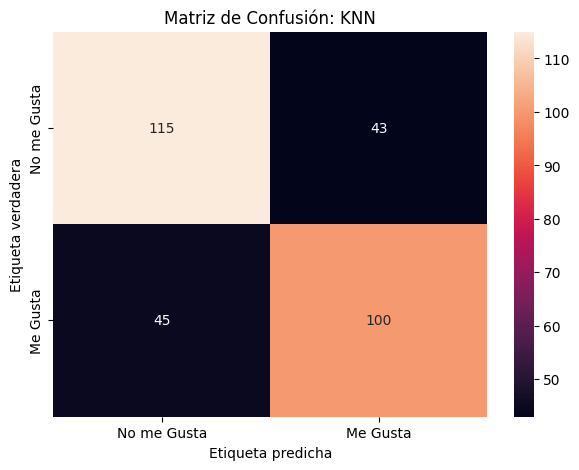

In [ ]:
#graficamos la matriz de confusión KNN
c_knn = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(7,5))
sns.heatmap(c_knn, annot=True, fmt='g', xticklabels=['No me Gusta', 'Me Gusta'], yticklabels=['No me Gusta', 'Me Gusta'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión: KNN')
plt.show()

##SVM (Support Vector Machines)

En esta seccion se realiza el entrenamiento con el modelo de SVM.

In [ ]:
svc = SVC()

param_grid = {'kernel': ['linear' , 'rbf'],'C': [0.1, 1, 10],'gamma': [0.1, 1, 10]}

grid_search_recall = GridSearchCV(svc, param_grid, cv=5, scoring='recall')
grid_search_recall.fit(X_train, y_train)

grid_search_accury = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search_accury.fit(X_train, y_train)

grid_search_f1macro = GridSearchCV(svc, param_grid, cv=5, scoring='f1_macro')
grid_search_f1macro.fit(X_train, y_train)


print("Mejores parámetros(recall):", grid_search_recall.best_params_)
print("Mejor score(recall):", grid_search_recall.best_score_,"\n")

print("Mejores parámetros(accury):", grid_search_accury.best_params_)
print("Mejor score(accury):", grid_search_accury.best_score_,"\n")

print("Mejores parámetros(f1):", grid_search_f1macro.best_params_)
print("Mejor score(f1):", grid_search_f1macro.best_score_,"\n")


Mejores parámetros(recall): {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}
Mejor score(recall): 0.8457142857142858 

Mejores parámetros(accury): {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Mejor score(accury): 0.6931069169522445 

Mejores parámetros(f1): {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Mejor score(f1): 0.6909350892582979 



usamos C=6 y gamma=9 porque es el que mejor resultado obtiene.
Generamos el modelo SVM y graficamos la Matriz de Confusión

Reporte de Clasificación:

              precision    recall  f1-score   support

           0       0.73      0.74      0.74       158
           1       0.71      0.70      0.71       145

    accuracy                           0.72       303
   macro avg       0.72      0.72      0.72       303
weighted avg       0.72      0.72      0.72       303



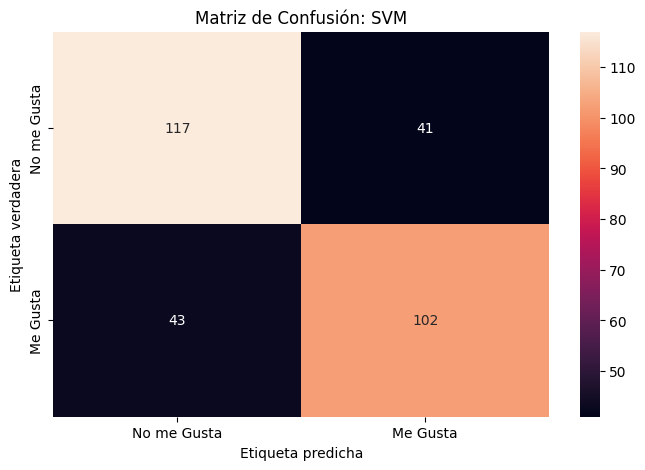

In [ ]:
svc_model = SVC(C=6, gamma=9, kernel='rbf')
svc_model.fit(X_train, y_train)


y_pred = svc_model.predict(X_test)


print("Reporte de Clasificación:\n")
print(classification_report(y_test, y_pred))


c_svc = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8,5))
sns.heatmap(c_svc, annot=True, fmt='g', xticklabels=['No me Gusta', 'Me Gusta'], yticklabels=['No me Gusta', 'Me Gusta'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión: SVM')
plt.show()



##Árbol de Decisión

En esta sección se realiza el entrenamiento con el modelo de Árbol de Decisión.
Usamos como hiperparámetro max_depth para configurar la profundidad máxima del árbol de decisión.

In [ ]:
#max_depth permite controlar la complejidad del modelo para evitar el overfitting
decision_tree = DecisionTreeClassifier(random_state=42 , max_depth=3)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

#Mostramos el rendimiento del modelo
print("Configuracion: ")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision (macro): {precision_score(y_test, y_pred, average='macro')}")
print(f"Recall (macro): {recall_score(y_test, y_pred, average='macro')}")
print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro')}")

Configuracion: 
Accuracy: 0.7095709570957096
Precision (macro): 0.7111504192872118
Recall (macro): 0.7110213880401571
F1 Score (macro): 0.7095677936563263


Generamos el modelo de Arbol de Decisión y graficamos la Matriz de Confusión

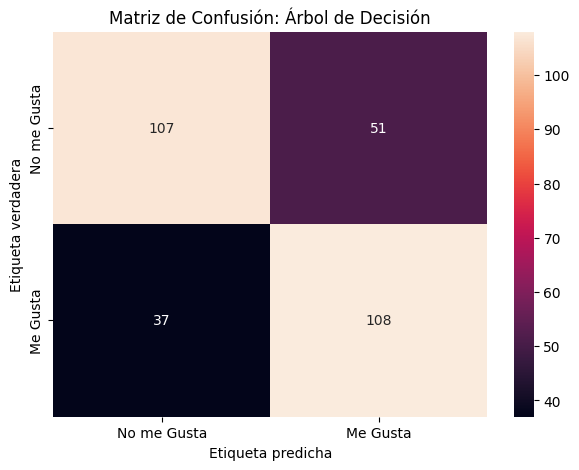

In [ ]:
c_tree = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(7,5))
sns.heatmap(c_tree, annot=True, fmt='g', xticklabels=['No me Gusta', 'Me Gusta'], yticklabels=['No me Gusta', 'Me Gusta'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión: Árbol de Decisión')
plt.show()


##Bayes (Naive Bayes)

En esta sección se realiza el entrenamiento con el modelo de Naive Bayes.

In [ ]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)

#Mostramos el rendimiento del modelo
print("Configuracion: ")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision (macro): {precision_score(y_test, y_pred, average='macro')}")
print(f"Recall (macro): {recall_score(y_test, y_pred, average='macro')}")
print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro')}")

Configuracion: 
Accuracy: 0.636963696369637
Precision (macro): 0.6383647798742138
Recall (macro): 0.63828022697512
F1 Score (macro): 0.6369597420704078


Generamos el modelo de Naive Bayes y graficamos la Matriz de Confusión

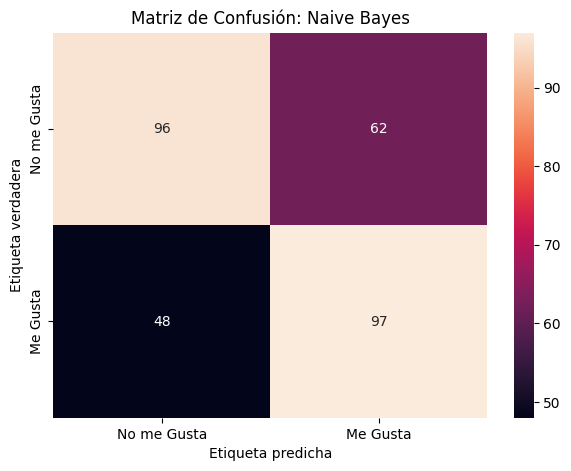

In [ ]:
c_naive = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(7,5))
sns.heatmap(c_naive, annot=True, fmt='g', xticklabels=['No me Gusta', 'Me Gusta'], yticklabels=['No me Gusta', 'Me Gusta'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión: Naive Bayes')
plt.show()


##Ensamble - Votación Mayoritaria

En esta sección tomamos los 4 modelos anteriores y realizamos un ensamble.
Mostramos el rendiminento de cada modelo.
Generamos la Matriz de Confusíon del Ensamble

KNN Accuracy: 0.7095709570957096
SVM Accuracy: 0.7227722772277227
Decision Tree Accuracy: 0.7095709570957096
Naive Bayes Accuracy: 0.636963696369637


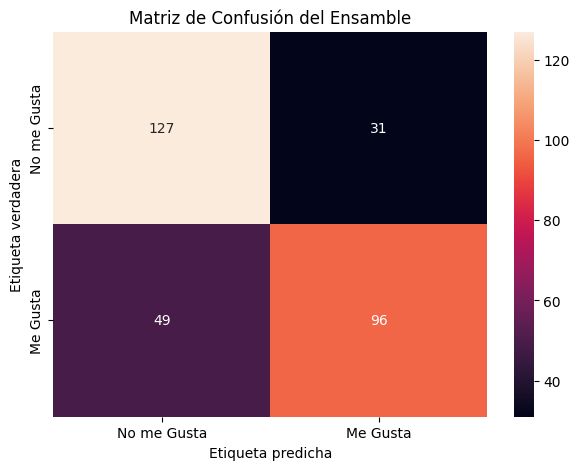

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=valor_k)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)  #mostrar rendimiento

# SVM
svm = SVC(C=6, gamma=9, kernel='rbf')
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)  #mostrar rendimiento

# Árbol de decisión
dtree = DecisionTreeClassifier(random_state=42 , max_depth=3)
dtree.fit(X_train, y_train)
dtree_predictions = dtree.predict(X_test)
dtree_accuracy = accuracy_score(y_test, dtree_predictions)
print("Decision Tree Accuracy:", dtree_accuracy)  #mostrar rendimiento

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_predictions = nb.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy) #mostrar rendimiento



# ENSABLE
final_predictions = []
for k, s, n, dt in zip(knn_predictions, svm_predictions, nb_predictions, dtree_predictions):

    votes = {0: 0, 1: 0, 2: 0}
    votes[k] += 1
    votes[s] += 1
    votes[n] += 1
    votes[dt] += 1

    majority_vote = max(votes, key=votes.get)
    final_predictions.append(majority_vote)

#Generamos la Matriz de Confusíon del Ensamble
c_ensamble = confusion_matrix(y_test, final_predictions)

plt.figure(figsize=(7,5))
sns.heatmap(c_ensamble, annot=True, fmt='g', xticklabels=['No me Gusta', 'Me Gusta'], yticklabels=['No me Gusta', 'Me Gusta'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión del Ensamble')
plt.show()

In [ ]:
#mostrar el rendimiento promedio
promedioRendimiento = (knn_accuracy + svm_accuracy + dtree_accuracy + nb_accuracy)/4
print(promedioRendimiento)

0.6947194719471947


##Conclusion:

Luego de realizar el analisis y entrenamiento de los modelos logramos obtener un rendimiento del 69,47% entre los 4 modelos

##Extra:

Como extra se realizara la misma practica usando los modelos de Random Forest y Gradient Boosting, se graficaran las matrices de confusion de cada modelo y se realizara una nueva matriz de ensamble con los 6 modelos, que se comparará con la matriz de ensamble original

In [ ]:
#Importar las librerias necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

Configuración Random Forest:
Accuracy: 0.735973597359736
Precision (macro): 0.7365954664341761
Recall (macro): 0.736905281536447
F1 Score (macro): 0.7359477124183007


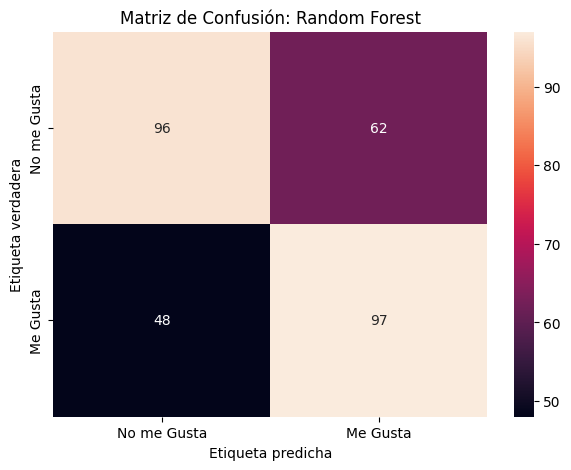

In [ ]:
# Creamos un clasificador de Random Forest con 100 arboles
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenamos el modelo
rf_classifier.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_rf = rf_classifier.predict(X_test)


# Evaluamos el rendimiento del modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf_macro = precision_score(y_test, y_pred_rf, average='macro')
recall_rf_macro = recall_score(y_test, y_pred_rf, average='macro')
f1_rf_macro = f1_score(y_test, y_pred_rf, average='macro')
# Mostramos el rendimiento del modelo
print("Configuración Random Forest:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision (macro): {precision_rf_macro}")
print(f"Recall (macro): {recall_rf_macro}")
print(f"F1 Score (macro): {f1_rf_macro}")

#realizamos la matriz de confusion
c_ranforest = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(c_ranforest, annot=True, fmt='g', xticklabels=['No me Gusta', 'Me Gusta'], yticklabels=['No me Gusta', 'Me Gusta'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión: Random Forest')
plt.show()


Configuración Gradient Boosting:
Accuracy: 0.7128712871287128
Precision (macro): 0.7132833609343676
Recall (macro): 0.7136185072020952
F1 Score (macro): 0.7128212390923054


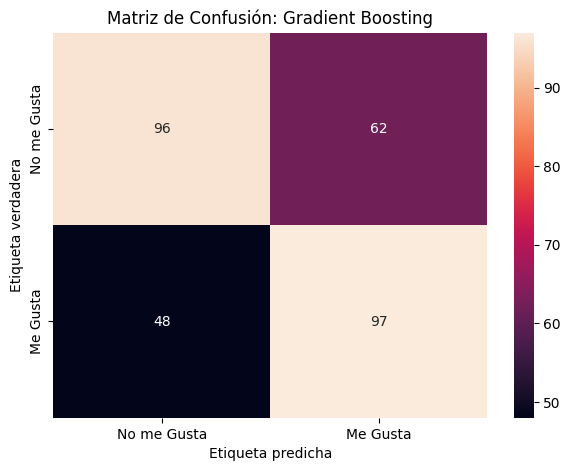

In [ ]:
#hacemos lo mismo con Gradient Boosting

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_classifier.fit(X_train, y_train)
y_pred_gb = gb_classifier.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb_macro = precision_score(y_test, y_pred_gb, average='macro')
recall_gb_macro = recall_score(y_test, y_pred_gb, average='macro')
f1_gb_macro = f1_score(y_test, y_pred_gb, average='macro')

print("Configuración Gradient Boosting:")
print(f"Accuracy: {accuracy_gb}")
print(f"Precision (macro): {precision_gb_macro}")
print(f"Recall (macro): {recall_gb_macro}")
print(f"F1 Score (macro): {f1_gb_macro}")


c_gradBoost = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(c_gradBoost, annot=True, fmt='g', xticklabels=['No me Gusta', 'Me Gusta'], yticklabels=['No me Gusta', 'Me Gusta'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión: Gradient Boosting')
plt.show()

KNN Accuracy: 0.7095709570957096
SVM Accuracy: 0.7227722772277227
Decision Tree Accuracy: 0.7095709570957096
Naive Bayes Accuracy: 0.636963696369637
Random Forest Accuracy: 0.735973597359736
Gradient Boosting Accuracy: 0.7128712871287128


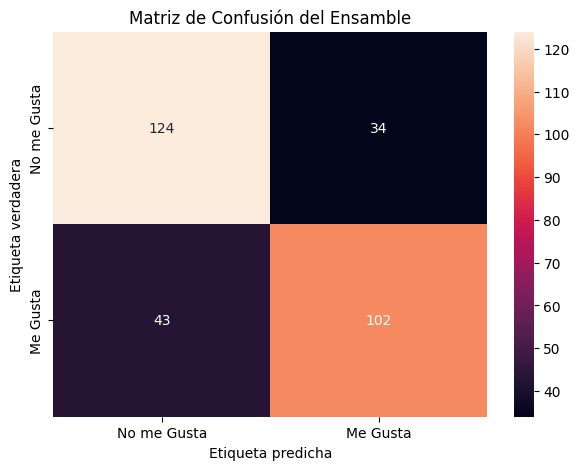

In [ ]:
#Realizamos la nueva matriz de confusion con votacion de los 6 modelos

# KNN
knn = KNeighborsClassifier(n_neighbors=valor_k)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)

# SVM
svm = SVC(C=6, gamma=9, kernel='rbf')
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

# Árbol de decisión
dtree = DecisionTreeClassifier(random_state=42 , max_depth=3)
dtree.fit(X_train, y_train)
dtree_predictions = dtree.predict(X_test)
dtree_accuracy = accuracy_score(y_test, dtree_predictions)
print("Decision Tree Accuracy:", dtree_accuracy)

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_predictions = nb.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)


# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
gb_predictios = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictios)
print("Gradient Boosting Accuracy:", gb_accuracy)


# ENSABLE
final_predictions = []
for k, s, n, dt, r, g in zip(knn_predictions, svm_predictions, nb_predictions, dtree_predictions, rf_predictions, gb_predictios):

    votes = {0: 0, 1: 0, 2: 0}
    votes[k] += 1
    votes[s] += 1
    votes[n] += 1
    votes[dt] += 1
    votes[r] += 1
    votes[g] += 1


    majority_vote = max(votes, key=votes.get)
    final_predictions.append(majority_vote)


c_ensamble2 = confusion_matrix(y_test, final_predictions)

plt.figure(figsize=(7,5))
sns.heatmap(c_ensamble2, annot=True, fmt='g', xticklabels=['No me Gusta', 'Me Gusta'], yticklabels=['No me Gusta', 'Me Gusta'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión del Ensamble')
plt.show()

In [ ]:
#mostrar el rendimiento promedio
promedioRendimiento2 = (knn_accuracy + svm_accuracy + dtree_accuracy + nb_accuracy + rf_accuracy + gb_accuracy)/6
print(promedioRendimiento2)

0.7046204620462047


Graficamos las dos matrices de Confusion, la de 4 y a de 6 modelos

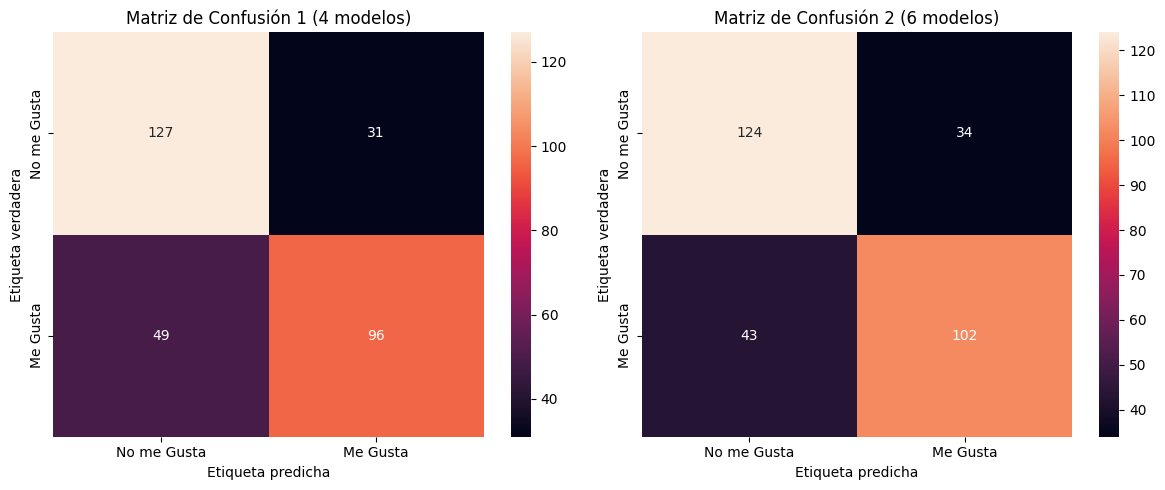

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(c_ensamble, annot=True, fmt='g', xticklabels=['No me Gusta', 'Me Gusta'], yticklabels=['No me Gusta', 'Me Gusta'] , ax=axes[0])
axes[0].set_title('Matriz de Confusión 1 (4 modelos)')
axes[0].set_xlabel('Etiqueta predicha')
axes[0].set_ylabel('Etiqueta verdadera')

sns.heatmap(c_ensamble2, annot=True, fmt='g', xticklabels=['No me Gusta', 'Me Gusta'], yticklabels=['No me Gusta', 'Me Gusta'] , ax=axes[1])
axes[1].set_title('Matriz de Confusión 2 (6 modelos)')
axes[1].set_xlabel('Etiqueta predicha')
axes[1].set_ylabel('Etiqueta verdadera')

plt.tight_layout()
plt.show()